In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load libraries and paths

In [246]:
import sys
sys.path.append("../../")

In [247]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pymc as pm 
import arviz as az
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import convert_aspect_to_cardinal_direction, apply_encoding, naturraumregionen_encoding
from src.modeling.utils import temporal_train_test_split
from src.modeling.bayesian_models import create_st_blr, create_blr
from src.modeling.predictions import BinaryClassification

In [248]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [249]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)


### Data Cleaning & Preparation

In [250]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 
training_data["month"] = (training_data.date.dt.month)

# encode aspect 
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)

# encode naturraumregionen
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

# replace None values of forest type with class "low and no vegetation (6)"
training_data["forest_type"].fillna(6, inplace=True)

# transform type of forest_type to int
training_data["forest_type"] = training_data["forest_type"].astype(int)

### Temporal train test split

In [252]:
X_train, X_test = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train["fire"], X_test["fire"]

### Feature Scaling

In [253]:
# Define the transformer
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
passthrough_columns = ['date', 'Pufferradi', 'fire', 'geometry', 'season', 'naturraumregionen_encoded', 'aspect_encoded', 'forest_type', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale)
    ],
    remainder='drop'
)


train_data_transformed = preprocessor.fit_transform(X_train)
test_data_transformed = preprocessor.transform(X_test)

X_train_features_to_scale = pd.DataFrame(train_data_transformed, columns=features_to_scale, index=X_train.index)
X_test_features_to_scale = pd.DataFrame(test_data_transformed, columns=features_to_scale, index=X_test.index)

X_train = pd.concat([X_train[passthrough_columns], X_train_features_to_scale], axis=1)
X_test = pd.concat([X_test[passthrough_columns], X_test_features_to_scale], axis=1)

### Modeling

In [241]:
coords = {"forest_type_classes": list(np.unique(training_data.forest_type)), 
          "aspect_classes": list(np.unique(training_data.aspect_encoded)), 
          "spatial_groups": list(np.unique(training_data.naturraumregionen_encoded)), 
          "temporal_groups": list(np.unique(training_data.month))}
print(coords)

{'forest_type_classes': [0, 1, 2, 3, 4, 5, 6], 'aspect_classes': [0, 1, 2, 3, 4, 5, 6, 7], 'spatial_groups': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'temporal_groups': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']}


In [255]:
X_train

,date,Pufferradi,fire,geometry,season,naturraumregionen_encoded,aspect_encoded,forest_type,month,ffmc,farmyard_density,hikingtrail_density,forestroad_density,railway_density,elevation,slope,population_density
2211,2003-01-13,None,0,POINT (483470.951 292623.815),0,7,5,4,01,-1.103995,-0.062053,-0.363876,1.458159,-0.15037,0.056685,0.124742,-0.330885
1782,2003-02-06,None,0,POINT (613125.622 464560.009),0,4,1,5,02,-0.631118,-0.062053,1.797776,0.054283,-0.15037,-0.818592,-0.907940,-0.327532
1554,2003-02-07,None,0,POINT (477630.741 487780.846),0,2,6,5,02,-0.622208,-0.062053,0.793037,1.575143,-0.15037,-0.973140,-0.706906,1.793648
1654,2003-02-10,None,0,POINT (642546.682 446999.376),0,0,1,5,02,-0.593506,-0.062053,-0.363876,-0.571549,-0.15037,-1.002015,-0.348343,-0.330885
1241,2003-02-13,None,0,POINT (579794.421 440859.155),0,4,4,0,02,-1.130484,-0.062053,-0.363876,-0.571549,-0.15037,-0.126697,0.408828,-0.330885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2016-04-27,None,0,POINT (631746.293 510871.677),1,0,6,5,04,-0.146198,-0.062053,-0.363876,1.434468,-0.15037,-1.009262,-1.329451,-0.330885
1968,2016-04-27,None,0,POINT (605075.332 331585.219),1,1,3,5,04,-1.897487,-0.062053,-0.363876,-0.571549,-0.15037,-1.026278,0.129076,-0.193386
1592,2016-05-01,None,0,POINT (445489.583 417098.299),1,4,4,0,05,-0.606981,-0.062053,-0.363876,-0.571549,-0.15037,1.176022,0.697503,-0.330885
380,2016-05-08,250,1,POINT (137957.684 391413.784),1,9,4,5,5,0.806786,-0.062053,-0.363876,0.750042,-0.15037,0.669390,0.270644,-0.330885


#### Spatio temporal Bayesian Logistic Regression Model

In [254]:
model_st_blr = create_st_blr(X_train, y_train, coords, "naturraumregionen_encoded", "month")

with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample()

TypeError: index must be integers or a boolean mask

#### Normal Bayesian Logistic Regression Model

In [126]:
model_blr = create_blr(X_train, y_train, coords)

with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample()

Finished [100%]: Average Loss = 800.74


### Check Model 

c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\arviz\plots\traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'mu_b1'}>,
        <AxesSubplot: title={'center': 'mu_b1'}>],
       [<AxesSubplot: title={'center': 'mu_b2'}>,
        <AxesSubplot: title={'center': 'mu_b2'}>],
       [<AxesSubplot: title={'center': 'mu_b3'}>,
        <AxesSubplot: title={'center': 'mu_b3'}>],
       [<AxesSubplot: title={'center': 'mu_b4'}>,
        <AxesSubplot: title={'center': 'mu_b4'}>],
       [<AxesSubplot: title={'center': 'mu_b5'}>,
        <AxesSubplot: title={'center': 'mu_b5'}>],
       [<AxesSubplot: title={'center': 'mu_b6'}>,
        <AxesSubplot: title={'center': 'mu_b6'}>],
       [<AxesSubplot: title={'center': 'mu_b7'}>,
        <AxesSubplot: title={'center': 'mu_b7'}>],
       [<AxesSubplot: title={'center': 'mu_b8'}>,
        <AxesSubplot: title={'center': 'mu_b8'}>],
       [<AxesSubplot: title={'center': 'mu_b9'}>,
        <AxesSubplot: title={'center': 'mu_b9'}>],
       [<AxesSubplot: title={'center': 'mu_b10'}>,
        <AxesSubplot: title={'center': '

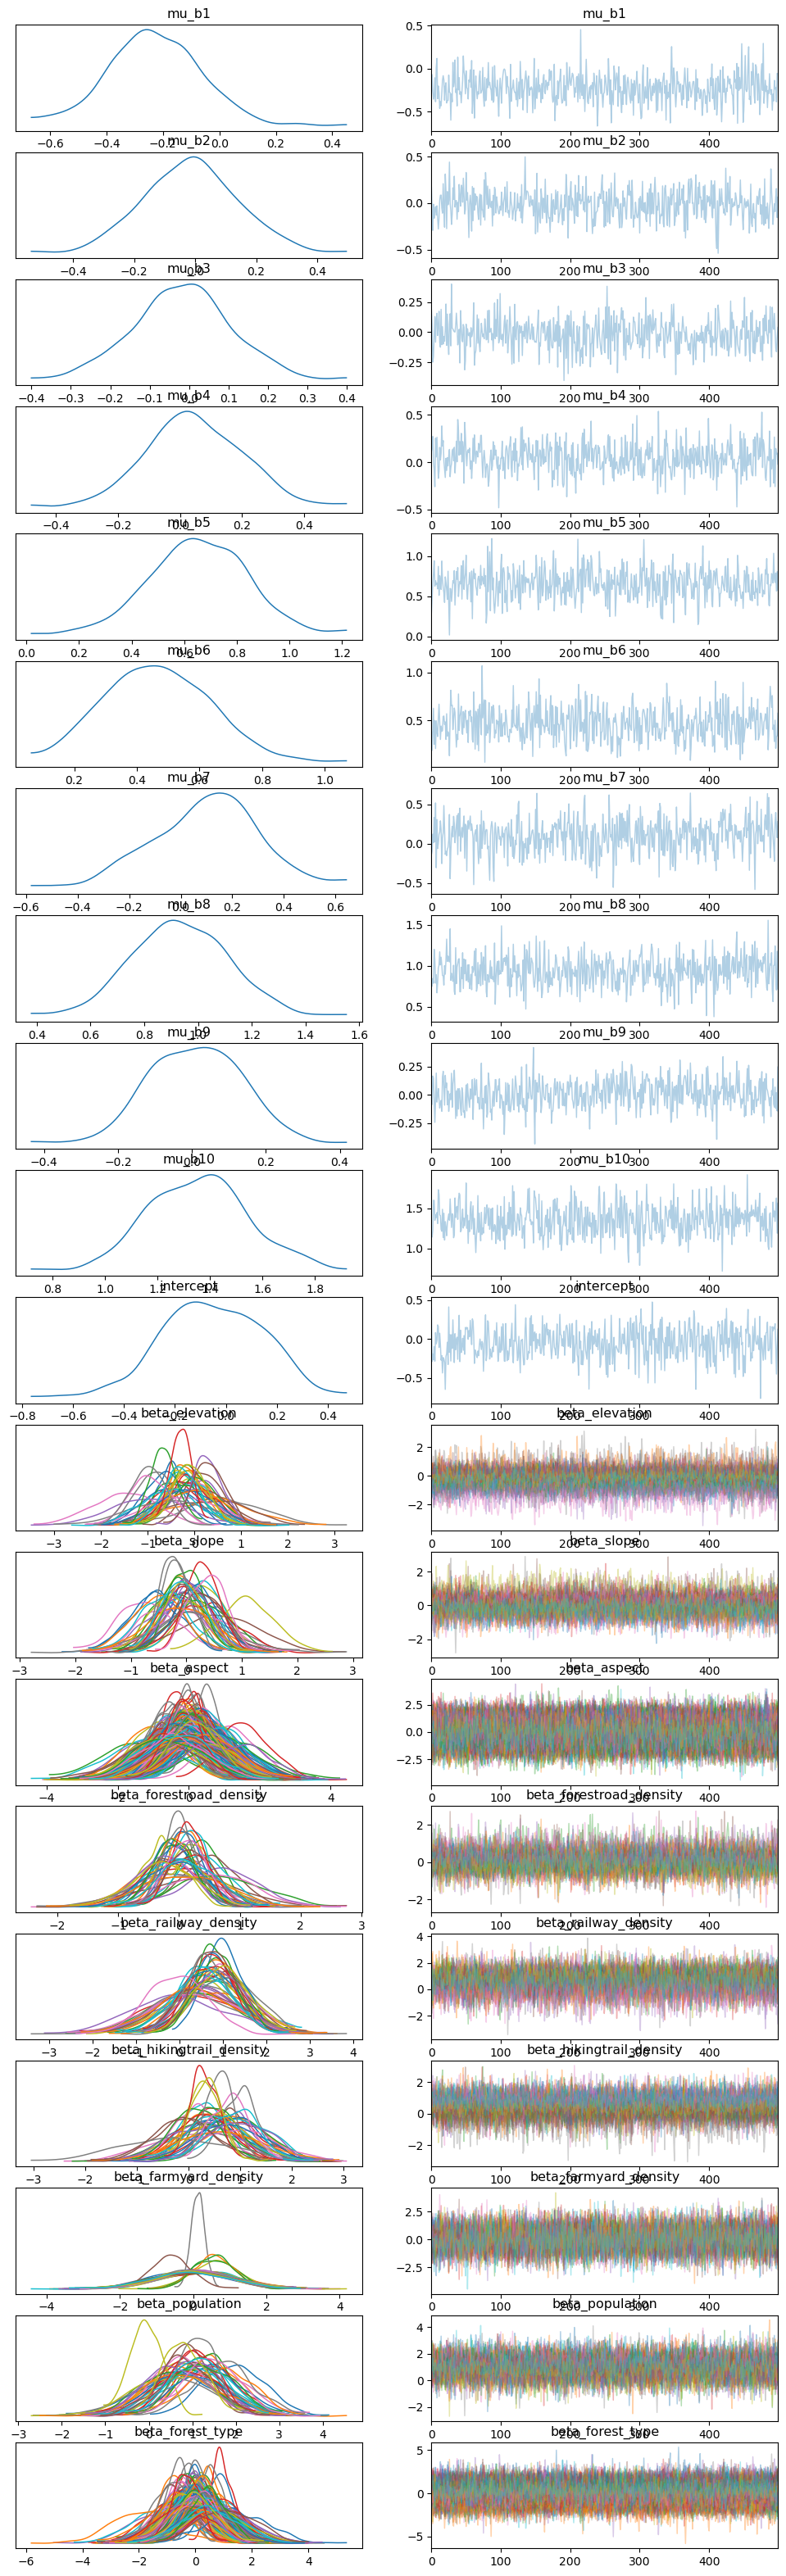

In [85]:
az.plot_trace(idata)

In [87]:
#az.plot_posterior(idata, var_names=["beta_elevation", "beta_ffmc", "beta_population"])

In [88]:
az.summary(idata, var_names=["beta_elevation", "beta_ffmc", "beta_population"])

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_elevation[0, 0]",-0.395,0.362,-1.032,0.310,0.017,0.012,469.0,363.0,NaN
"beta_elevation[0, 1]",-0.182,0.368,-0.854,0.476,0.016,0.013,514.0,460.0,NaN
"beta_elevation[0, 2]",-0.095,0.367,-0.791,0.590,0.016,0.011,558.0,501.0,NaN
"beta_elevation[0, 3]",-0.376,0.525,-1.423,0.570,0.022,0.017,564.0,397.0,NaN
"beta_elevation[1, 0]",0.051,0.485,-0.900,0.920,0.022,0.015,501.0,499.0,NaN
...,...,...,...,...,...,...,...,...,...
"beta_population[8, 3]",0.821,0.649,-0.355,2.119,0.029,0.021,519.0,472.0,NaN
"beta_population[9, 0]",1.447,0.630,0.247,2.546,0.027,0.020,532.0,495.0,NaN
"beta_population[9, 1]",1.073,0.453,0.170,1.864,0.020,0.014,500.0,315.0,NaN
"beta_population[9, 2]",0.788,0.489,-0.078,1.728,0.025,0.018,393.0,509.0,NaN


### Predictions on test set

#### ST BLR

In [127]:
y_dummy = [0 for i in y_test]
X_new = {
    "elevation": X_test.elevation,
    "slope": X_test.slope,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density,
    "railway_density": X_test.railway_density,
    "hikingtrail_density": X_test.hikingtrail_density,
    "farmyard_density": X_test.farmyard_density,
    "population": X_test.population_density,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "spatial_groups_idx": X_test.naturraumregionen_encoded,
    "temporal_groups_idx": X_test.season,
    "fire": y_dummy
    }


seed = 0
st_blr_prediction_obj = BinaryClassification(model_st_blr, st_blr_idata, X_new, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

accuracy = accuracy_score(y_test, st_blr_preds.y_pred)
precision = precision_score(y_test, st_blr_preds.y_pred)
recall = recall_score(y_test, st_blr_preds.y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Sampling: [y_pred]


Accuracy:  0.7529761904761905
Precision:  0.7855227882037533
Recall:  0.7730870712401056


#### BLR

In [128]:
y_dummy = [0 for i in y_test]
X_new = {
    "elevation": X_test.elevation,
    "slope": X_test.slope,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density,
    "railway_density": X_test.railway_density,
    "hikingtrail_density": X_test.hikingtrail_density,
    "farmyard_density": X_test.farmyard_density,
    "population": X_test.population_density,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

seed = 0
blr_prediction_obj = BinaryClassification(model_blr, blr_idata, X_new, seed, "y_pred", "p")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

accuracy = accuracy_score(y_test, blr_preds.y_pred)
precision = precision_score(y_test, blr_preds.y_pred)
recall = recall_score(y_test, blr_preds.y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Sampling: [y_pred]


Accuracy:  0.7648809523809523
Precision:  0.7900262467191601
Recall:  0.7941952506596306


### Comparison to Random Forest

In [102]:
features_to_consider = ["season", "naturraumregionen_encoded", "aspect_encoded", 
                        "forest_type", "ffmc",	"farmyard_density", "hikingtrail_density", 
                        "forestroad_density", "railway_density", "elevation", "slope", 
                        "population_density"]

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train.loc[:, features_to_consider], y_train)
y_pred = rf_clf.predict(X_test.loc[:, features_to_consider])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.7708333333333334
Precision:  0.8186968838526912
Recall:  0.762532981530343


### Document & Visualize results

In [199]:
st_blr_preds.index = y_test.index
st_blr_preds["y_true"] = y_test
result = training_data.loc[:, ["date", "Pufferradi", "season", "naturraumregionen_encoded", "geometry"]].join(st_blr_preds)
result.dropna(subset="y_true", inplace=True)
result.Pufferradi = result.Pufferradi.astype("float")


Create table with sample size, mean location uncertainty, mean prediction uncertainty, performance metrics for each subgroup 

In [222]:
groups = ["season", "naturraumregionen_encoded"]
groups = ["season"]
groups = ["naturraumregionen_encoded"]

agg_funcs = {
    'y_true': 'count',  
    'hdi_width': 'mean',  
    'Pufferradi': 'mean',
}

grouped_result = result.groupby(groups).agg(agg_funcs)
grouped_result.rename(columns={'y_true': 'count', 'hdi_width': 'hdi_width_mean', 'Pufferradi': 'Pufferradi_mean'}, inplace=True)

def calculate_accuracy(group):
    return accuracy_score(group.y_true, group.y_pred)

def calculate_precision(group):
    return precision_score(group.y_true, group.y_pred)

def calculate_recall(group):
    return recall_score(group.y_true, group.y_pred)

# Group by specific columns and apply the custom function to two columns
grp_accuracy = result.groupby(groups).apply(lambda x: calculate_accuracy(x))
grp_precision = result.groupby(groups).apply(lambda x: calculate_precision(x))
grp_recall = result.groupby(groups).apply(lambda x: calculate_recall(x))
grp_performance = pd.concat([grp_accuracy, grp_precision, grp_recall], axis=1)
grp_performance.columns = ["accuracy", "precision", "recall"]

grouped_result_final = grouped_result.join(grp_performance)

In [223]:
grouped_result_final

,count,hdi_width_mean,Pufferradi_mean,accuracy,precision,recall
naturraumregionen_encoded,,,,,,
0,62,0.381921,191.190476,0.822581,0.860465,0.880952
1,59,0.472665,225.263158,0.661017,0.750000,0.710526
2,59,0.393399,216.666667,0.762712,0.696970,0.851852
3,45,0.417606,296.666667,0.800000,0.857143,0.750000
4,120,0.338233,209.230769,0.733333,0.717391,0.634615
5,67,0.384210,147.285714,0.641791,0.677419,0.600000
6,26,0.462285,251.052632,0.807692,0.818182,0.947368
7,20,0.373221,248.461538,0.650000,0.800000,0.615385
8,94,0.280583,178.867925,0.787234,0.770492,0.886792


Graph with prediction score + uncertainty on Y-axis & time (day of year) on X-axis

In [228]:
result["doy"] = result.date.dt.day_of_year

In [229]:
result

,date,Pufferradi,season,naturraumregionen_encoded,geometry,y_pred,p_pred,hdi_lower,hdi_upper,hdi_width,binary_entropy,y_true,doy
0,2020-11-11,250.0,3,9,POINT (227864.936 381185.836),1.0,0.868,0.809683,0.999719,0.190036,-1.442695e-08,1.0,316
3,2020-08-20,30.0,2,9,POINT (384881.620 414532.487),1.0,0.714,0.547124,0.991453,0.444328,-1.442695e-08,1.0,233
8,2020-06-01,30.0,1,9,POINT (275342.219 384473.166),1.0,0.934,0.882919,0.996877,0.113959,-1.442695e-08,1.0,153
9,2020-06-01,50.0,1,9,POINT (208197.750 399390.369),1.0,0.606,0.344170,0.906015,0.561845,-1.442695e-08,1.0,153
10,2020-05-23,15.0,1,9,POINT (281679.864 389801.635),1.0,1.000,0.999043,1.000000,0.000957,-1.442695e-08,1.0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2017-03-04,30.0,0,0,POINT (641070.221 414873.876),1.0,0.900,0.861732,0.999869,0.138137,-1.442695e-08,1.0,63
360,2016-12-10,250.0,3,0,POINT (645689.011 409172.100),0.0,0.428,0.072443,0.698025,0.625582,-1.442695e-08,1.0,345
1456,2019-06-29,NaN,1,0,POINT (629436.210 403117.796),1.0,0.746,0.572654,0.985378,0.412723,-1.442695e-08,0.0,180
1642,2018-12-21,NaN,3,0,POINT (636576.467 402467.772),0.0,0.172,0.000443,0.274815,0.274373,-1.442695e-08,0.0,355


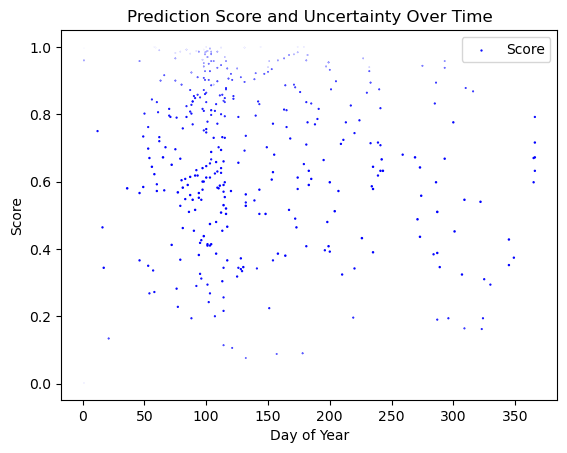

In [239]:
only_fire = result[result["y_true"] == 1]

# Plot the prediction score
plt.scatter(only_fire['doy'], only_fire['p_pred'], label='Score', color='blue', s=only_fire["hdi_width"])

# Plot the uncertainty interval (e.g., confidence interval or standard deviation)
#plt.fill_between(result['doy'], result['hdi_lower'], result['hdi_upper'], color='skyblue', alpha=0.3, label='Uncertainty')

# Add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Score')
plt.title('Prediction Score and Uncertainty Over Time')

# Add legend
plt.legend()

# Show plot
plt.show()